## Quickstart

In this section, users will learn

1. the data input required to create a basic MMM
2. the fit and predict process of MMM
2. basic usage of the MMM

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import karpiu
from karpiu.models import MMM

pd.set_option("display.float_format", lambda x: "%.5f" % x)
pd.set_option("display.max_rows", 50)

print(karpiu.__version__)

0.0.1


In [2]:
%load_ext autoreload
%autoreload 2

### Data Input

In [3]:
RAW_DATA_FILE = "resource/non-seasonal/df.csv"
SCALABILITY_FILE = "resource/non-seasonal/scalability_df.csv"
ADSTOCK_FILE = "resource/non-seasonal/adstock_df.csv"
paid_channels = ["promo", "radio", "search", "social", "tv"]

This is the core spend and response(the sales) input data.

In [4]:
df = pd.read_csv(RAW_DATA_FILE, parse_dates=["date"])
train_df = df[:-28]
test_df = df[-28:]
df.head(5)

,date,sales,promo,radio,search,social,tv
0,2019-01-01,536.00000,10020.00000,4735.00000,4505.00000,1518.00000,1796.00000
1,2019-01-02,885.00000,11904.00000,2211.00000,3355.00000,0.00000,790.00000
2,2019-01-03,627.00000,0.00000,7662.00000,3373.00000,2550.00000,367.00000
3,2019-01-04,681.00000,0.00000,8391.00000,2743.00000,0.00000,197.00000
4,2019-01-05,1029.00000,1600.00000,8452.00000,4005.00000,1324.00000,1245.00000


In [5]:
scalability_df = pd.read_csv(SCALABILITY_FILE)
scalability_df.head(5)

,regressor,scalability
0,promo,1.10000
1,radio,0.75000
2,search,1.30000
3,social,1.50000
4,tv,0.90000


Note that `adstock_df` is optional. If users choose to provide one, make sure the index is named as `regressor`.

In [6]:
adstock_df = pd.read_csv(ADSTOCK_FILE, index_col="regressor")
adstock_df

,d_0,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,...,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27
regressor,,,,,,,,,,,,,,,,,,,,,
promo,0.02907,0.03052,0.03205,0.03365,0.03533,0.03710,0.03895,0.04090,0.04295,0.04509,...,0.03534,0.03428,0.03325,0.03226,0.03129,0.03035,0.02944,0.02856,0.02770,0.02687
radio,0.07411,0.08004,0.08644,0.09336,0.10083,0.10890,0.11761,0.12702,0.12702,0.05081,...,0.00001,0.00001,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
search,0.11070,0.12177,0.13395,0.14734,0.16208,0.16208,0.08104,0.04052,0.02026,0.01013,...,0.00002,0.00001,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
social,0.03901,0.05851,0.08777,0.08777,0.07899,0.07109,0.06399,0.05759,0.05183,0.04665,...,0.01807,0.01626,0.01464,0.01317,0.01186,0.01067,0.00960,0.00864,0.00778,0.00700
tv,0.10261,0.17956,0.17956,0.13467,0.10100,0.07575,0.05681,0.04261,0.03196,0.02397,...,0.00180,0.00135,0.00101,0.00076,0.00057,0.00043,0.00032,0.00024,0.00018,0.00014


### Fitting a Basic MMM

In [7]:
mmm = MMM(
    kpi_col="sales",
    date_col="date",
    spend_cols=paid_channels,
    scalability_df=scalability_df,
    event_cols=[],
    seed=2022,
    adstock_df=adstock_df,
)

2023-02-22 16:36:26 - karpiu-mmm - INFO - Initialize model


For now, users can skip the hyper-parameters fitting section and directly set some prepared hyper-parameters.

In [8]:
best_params = {
    "damped_factor": 0.949,
    "level_sm_input": 0.0245,
    "slope_sm_input": 0.0943,
}
mmm.set_hyper_params(best_params)

2023-02-22 16:36:26 - karpiu-mmm - INFO - Set hyper-parameters.
2023-02-22 16:36:26 - karpiu-mmm - INFO - Best params damped_factor set as 0.94900
2023-02-22 16:36:26 - karpiu-mmm - INFO - Best params level_sm_input set as 0.02450
2023-02-22 16:36:26 - karpiu-mmm - INFO - Best params slope_sm_input set as 0.09430


Fit the model with supplied dataframe.

In [9]:
mmm.fit(train_df)

2023-02-22 16:36:26 - karpiu-mmm - INFO - Fit final model.
2023-02-22 16:36:26 - karpiu-mmm - INFO - Deriving saturation constants...
2023-02-22 16:36:26 - karpiu-mmm - INFO - Derived saturation constants.
2023-02-22 16:36:26 - karpiu-mmm - INFO - Build a default regression scheme
2023-02-22 16:36:26 - orbit - INFO - Sampling (PyStan) with chains: 1, cores: 8, temperature: 1.000, warmups (per chain): 400 and samples(per chain): 100.


chain 1 |          | 00:00 Status

2023-02-22 16:36:42 - karpiu-mmm - INFO - Spend channels regression coefficients sum (0.28600515000000004) is within common range (0, 0.8].


### Extracting Insights from the Model

### Attribution

In [10]:
from karpiu.explainability import Attributor

In [11]:
ATTR_START = "2019-03-01"
ATTR_END = "2019-03-31"
attributor = Attributor(model=mmm, start=ATTR_START, end=ATTR_END)
activities_attr_df, spend_attr_df, spend_df, cost_df = attributor.make_attribution()

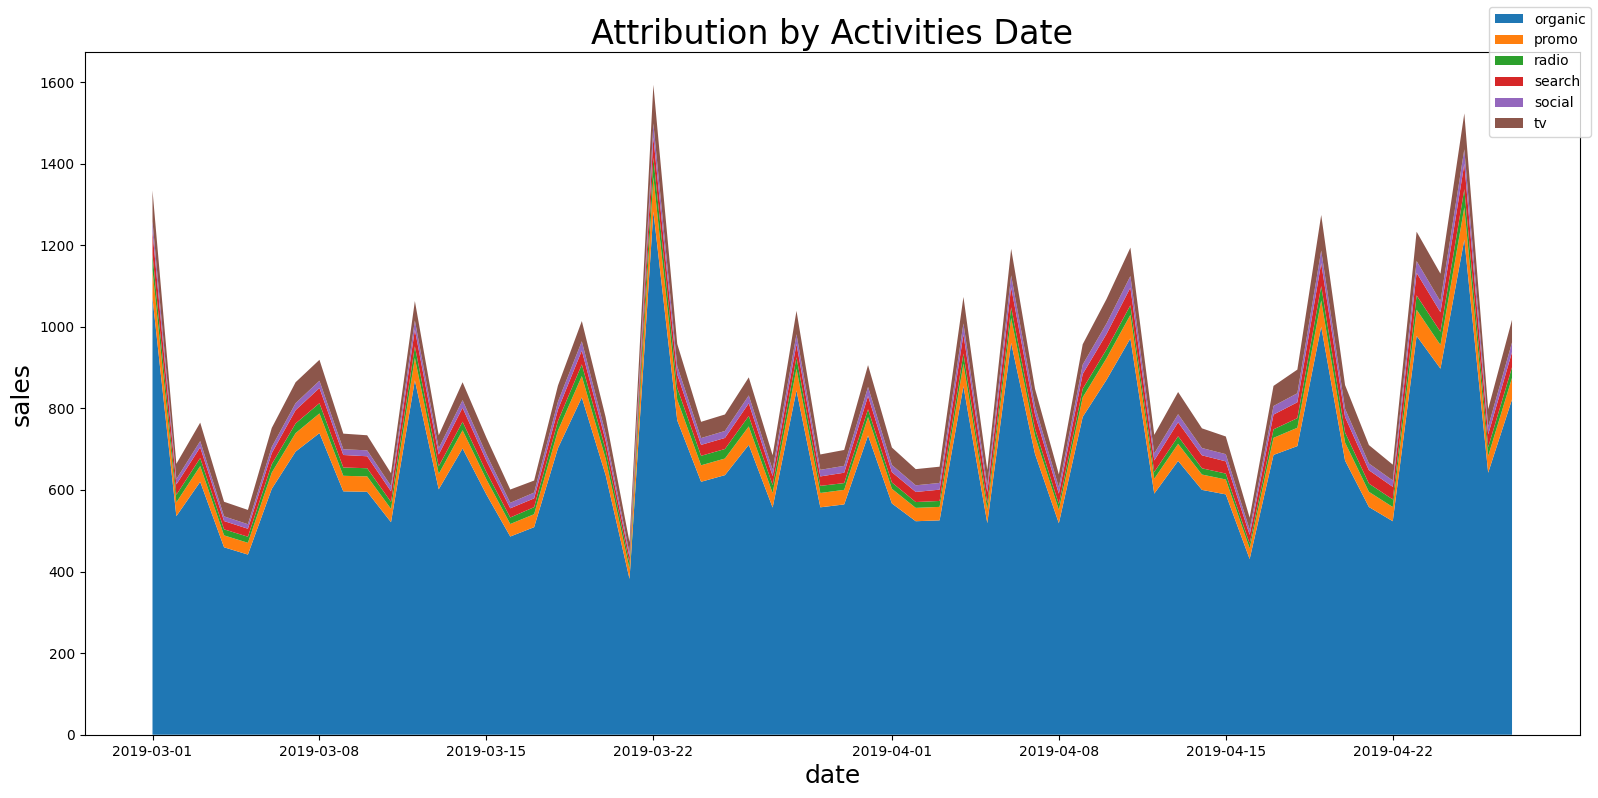

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.stackplot(
    activities_attr_df["date"].values,
    activities_attr_df[["organic"] + paid_channels].values.transpose(),
    labels=["organic"] + paid_channels,
)
ax.set_title("Attribution by Activities Date", fontdict={"fontsize": 24})
ax.set_xlabel("date", fontdict={"fontsize": 18})
ax.set_ylabel("sales", fontdict={"fontsize": 18})
fig.legend()
fig.tight_layout();

### Cost and Efficiency Analysis

In [13]:
from karpiu.planning import CostCurves

In [14]:
cc = CostCurves(
    model=mmm,
    curve_type="individual",
    n_steps=50,
    channels=paid_channels,
    spend_start=ATTR_START,
    spend_end=ATTR_END,
)
cc.generate_cost_curves()

  0%|          | 0/5 [00:00<?, ?it/s]

To prevent overflow, users can provide a scaler in plotting the cost curves.

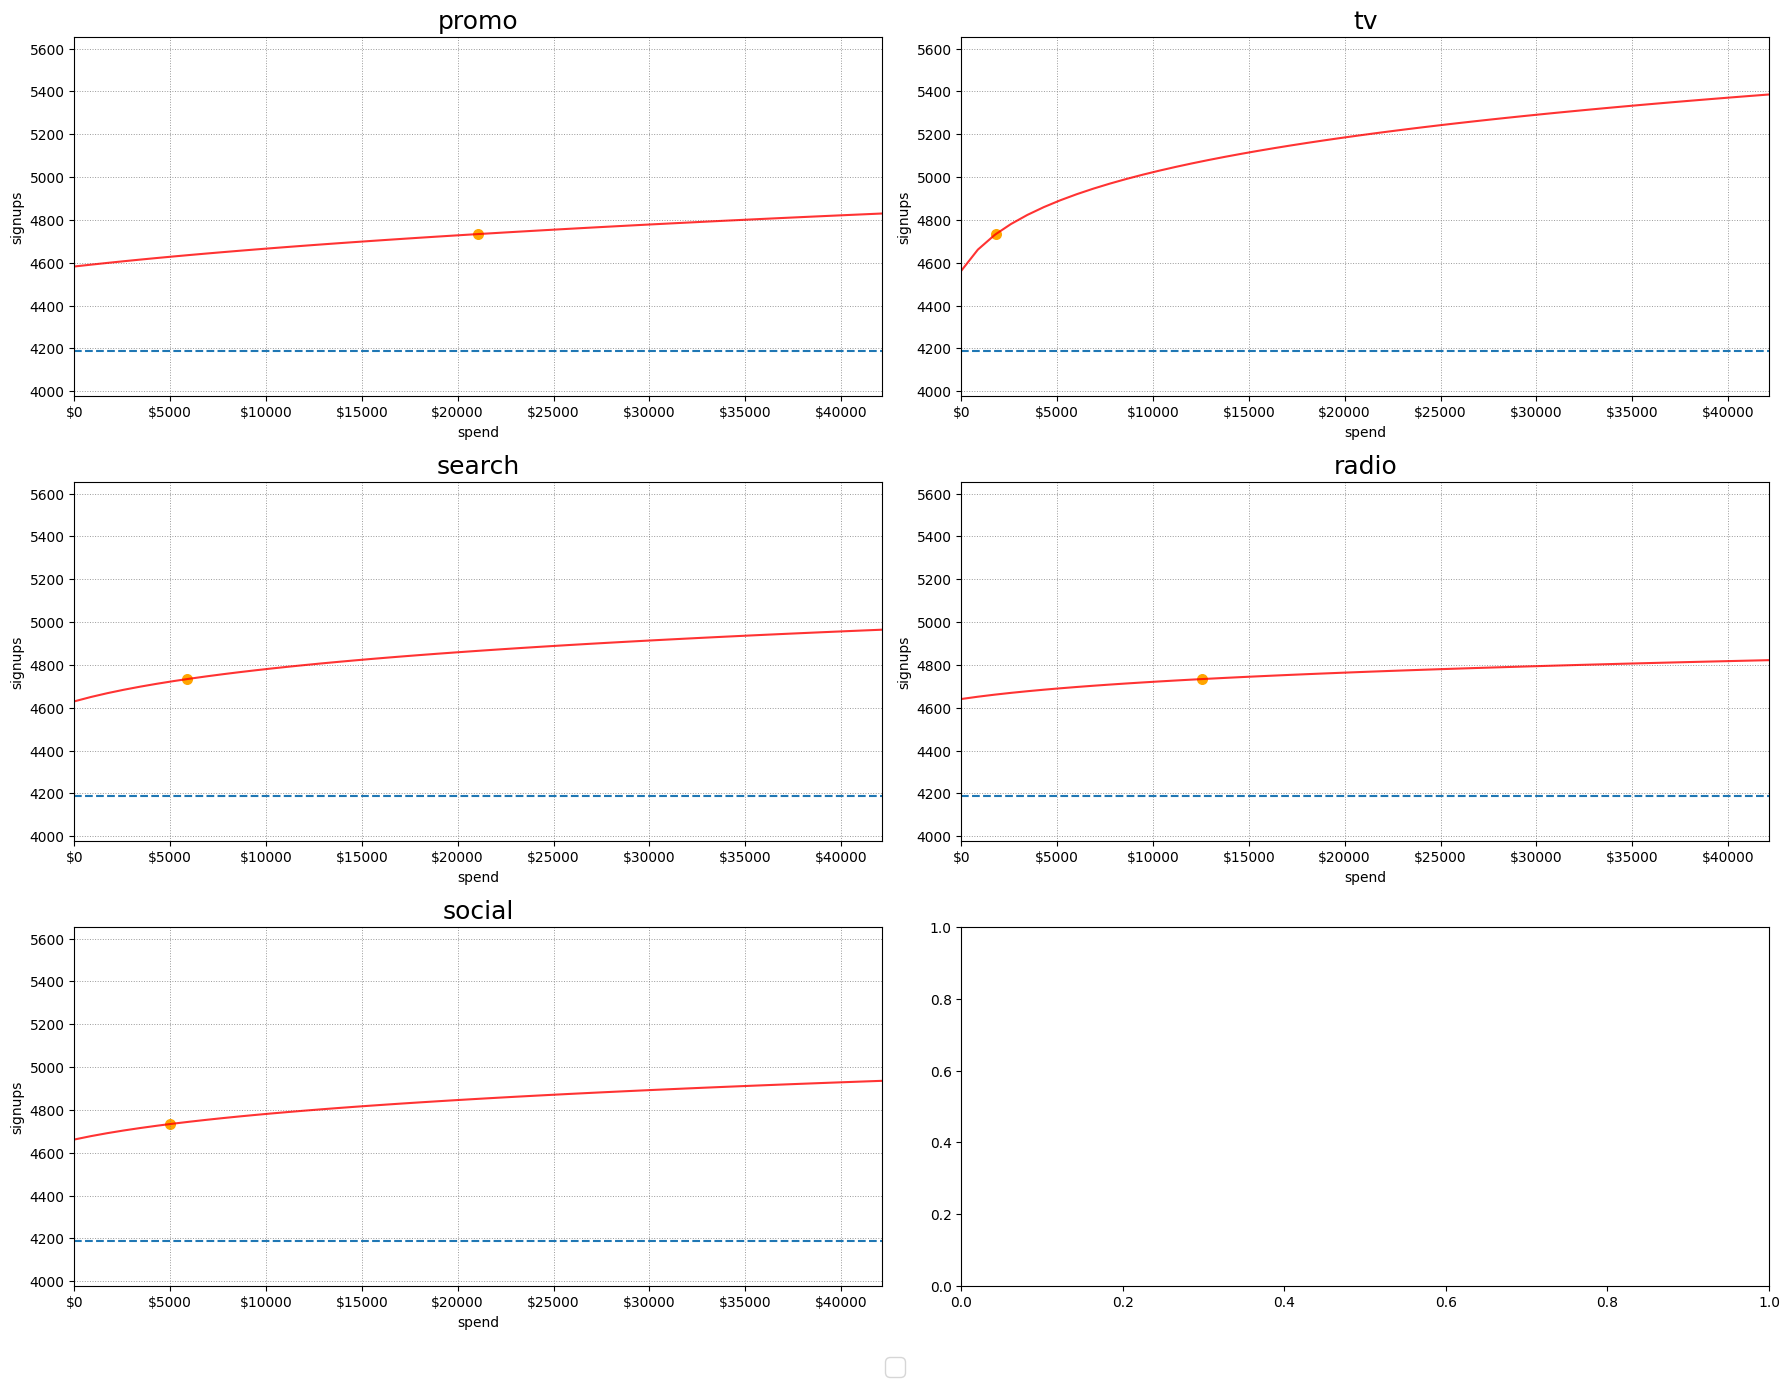

In [15]:
cc.plot(spend_scaler=10, outcome_scaler=10);

### Model Regression Coefficents

In [16]:
mmm.get_regression_summary()

,regressor,sign,coef_p50,coef_p05,coef_p95,Pr(coef >= 0),Pr(coef < 0),loc_prior,scale_prior
0,promo,Positive,0.07491,0.00881,0.16672,1.00000,0.00000,0.00000,0.10000
1,radio,Positive,0.03543,0.00688,0.09006,1.00000,0.00000,0.00000,0.10000
2,search,Positive,0.06035,0.00579,0.13321,1.00000,0.00000,0.00000,0.10000
3,social,Positive,0.03962,0.00330,0.14538,1.00000,0.00000,0.00000,0.10000
4,tv,Positive,0.07569,0.03234,0.12534,1.00000,0.00000,0.00000,0.10000


### Forecast Future Outcome

Prediction interval is not supported yet but will be available in future version.

In [17]:
from orbit.diagnostics.plot import plot_predicted_data

In [18]:
pred_df = mmm.predict(df)

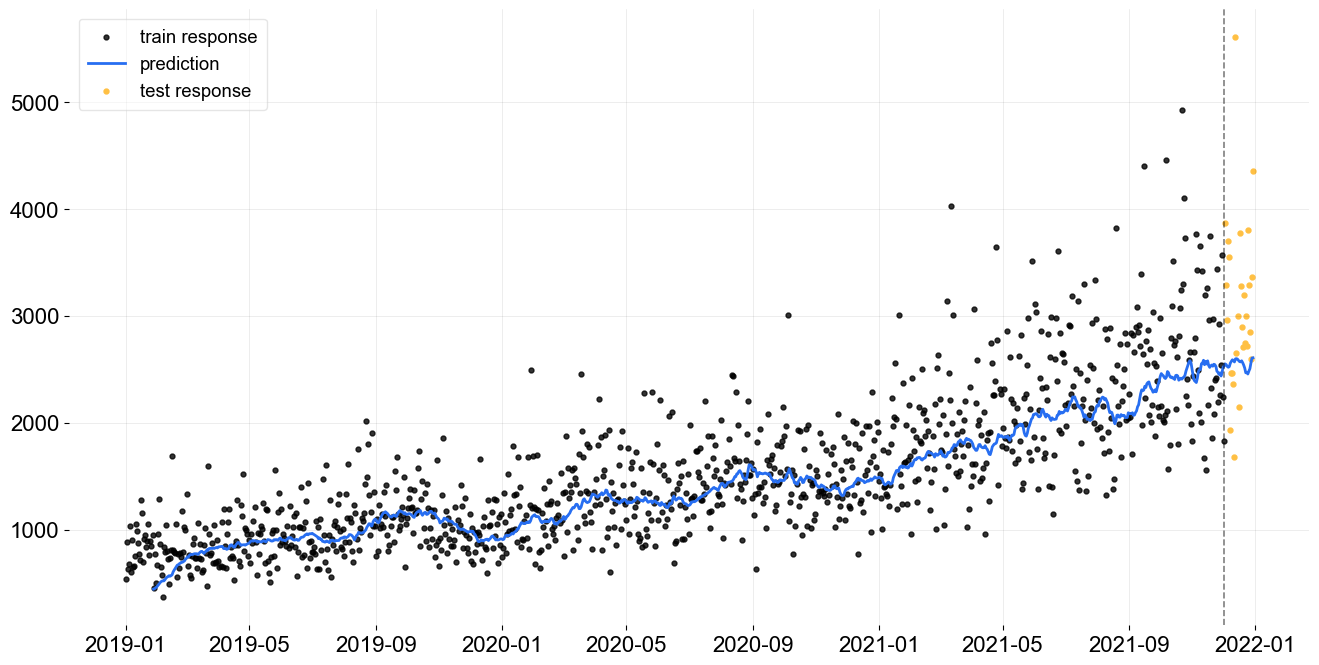

In [19]:
plot_predicted_data(
    training_actual_df=train_df,
    predicted_df=pred_df,
    date_col="date",
    actual_col="sales",
    test_actual_df=test_df,
);

Note that this is a non-seasonal model. To model seasonalities and events, check subsequent section.

## Dump Model for Future Usage

In [20]:
import pickle

with open("./resource/model.pkl", "wb") as f:
    pickle.dump(mmm, f, protocol=pickle.HIGHEST_PROTOCOL)